# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак:

    Price — цена (евро)

## Подготовка данных

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.dummy import DummyRegressor

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [7]:
df = pd.read_csv('datasets/autos.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Посмотрим на наличие дупликатов

In [11]:
df.duplicated().sum()

4

Незначительное количество - можем удалить

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

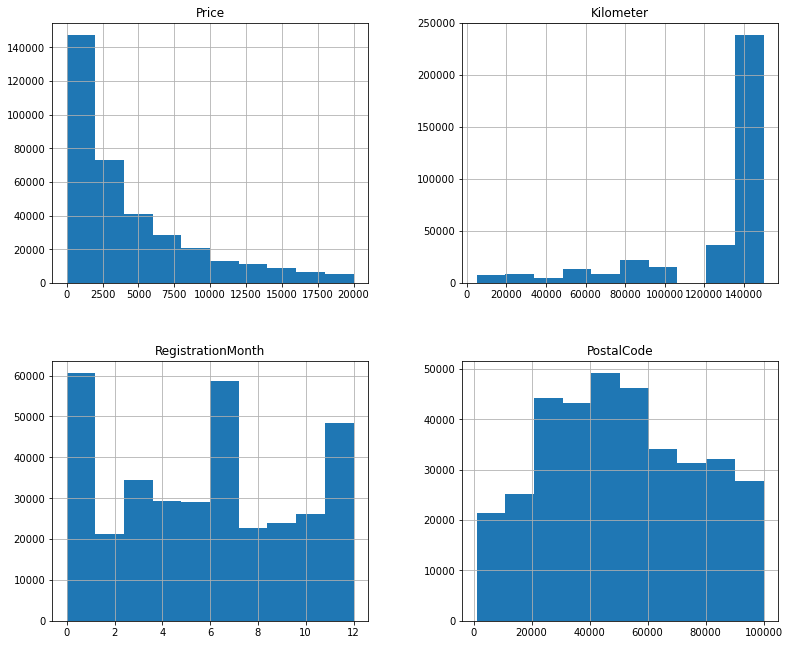

In [13]:
df.loc[:, (df.columns !='RegistrationYear') & (df.columns !='Power') & (df.columns !='NumberOfPictures')].hist(figsize=(13, 11));

Переимунем столбцы под змеиный регистр

In [14]:
df.columns = df.columns.str.lower()

In [15]:
df = df.rename(columns = {
    'datecrawled':'date_crawled',
    'vehicletype':'vehicle_type',
    'registrationyear':'registration_year',
    'registrationmonth':'registration_month',
    'fueltype':'fuel_type',
    'datecreated':'date_created',
    'numberofpictures':'number_of_pictures',
    'postalcode':'postal_code',
    'lastseen':'last_seen'
    })

In [16]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Работа с пропусками

In [17]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Заполним пропуски наиболее часто встречаемыми значениями:

In [18]:
df = df.fillna(df.mode().iloc[0])

In [19]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [20]:
df.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,no,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


### Работа с аномальными значениями

Вначале удалим столбцы, которые не принесут нам стоящей информации ( на мой взгляд):

    number_of_pictures - кол-во изображений не влияет на стоимость автомобиля, поскольку цена определяется по другим парметрам. Люди смотрят больше на характеристики;
    date_crawled, date_created - дата скаичивания объявления из базы и его создания также не влияет, т.к. является скорее технической информацией; 
    last_seen - последняя активность пользователя тоже является незначимым показателем;
    postal_code - почтовый индекс имеет отношение к личным данным пользователя, а не к опредлению стоимости;
    registration_month - при продаже автомобиля смотрят на год регистрации, а не на месяц.

In [21]:
df.shape

(354365, 16)

In [22]:
df = df.drop(['number_of_pictures', 'date_created', 'last_seen', 'date_crawled', 'postal_code', 'registration_month'], axis = 1)

In [23]:
df.shape

(354365, 10)

Выведим еще раз describe, чтобы посмотреть на аномальные значения и решим, как их от них избавиться

In [24]:
df.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


<b>Price</b>

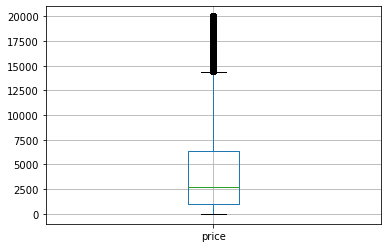

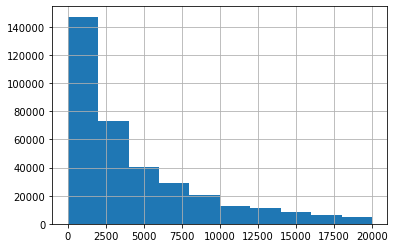

In [25]:
df.boxplot('price');
plt.show()
df['price'].hist();

Машины, у которых очень маленькая стоимость, думаю, можно удалить из нашей выборки. Может это ошибка или какой-нибудь металоллом, поэтому лучше убрать. Дорогостоящие трогать не будем, т.к. это вполне объяснимо.

In [26]:
df = df.query('price > 100')

In [27]:
df['price'].describe()

count    340020.000000
mean       4602.498115
std        4514.920302
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

<b>Registration_year</b>

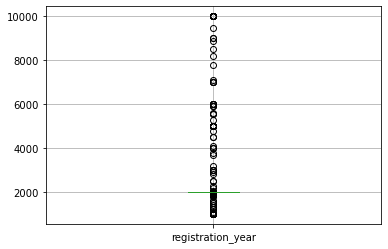

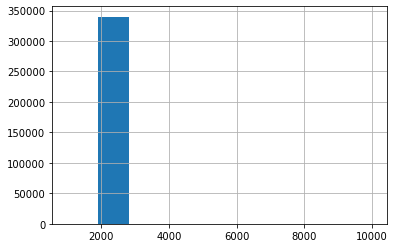

In [28]:
df.boxplot('registration_year');
plt.show()
df['registration_year'].hist();

Не знаю, какие машины можно считать старыми, но явно те, что зарегитрированы в 1000 году - не подходят... Не будем особо много убирать и оставим машины с 1967 года (вдруг, там будет Chevrolet Impala 1967 года)

In [29]:
df = df.query('1967 <= registration_year <= 2023')
df['registration_year'].describe()

count    339154.000000
mean       2003.327220
std           6.949708
min        1967.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64

<b>Power</b>

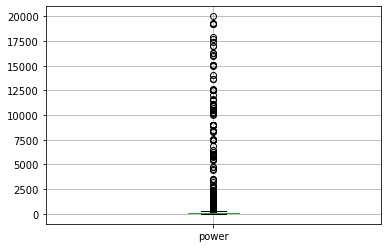

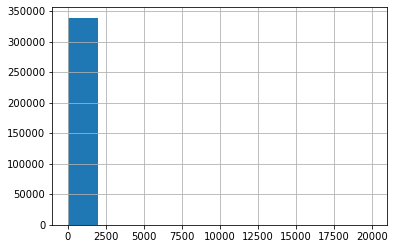

In [30]:
df.boxplot('power');
plt.show()
df['power'].hist();

Из того, что я нашла в интернете - оставляем машины с мощностью от 50 л.с. до 1500 (я нашла, что максимум это 2000, но не думаю, что такое нам пригодится. В среднем, у элитных внедорожников до 450 л.с., поэтому 1500 должно хватить)

In [31]:
df = df.query('50 <= power <= 1500')
df['power'].describe()

count    299355.000000
mean        122.334135
std          57.366634
min          50.000000
25%          80.000000
50%         114.000000
75%         150.000000
max        1500.000000
Name: power, dtype: float64

<b>Kilometer</b>

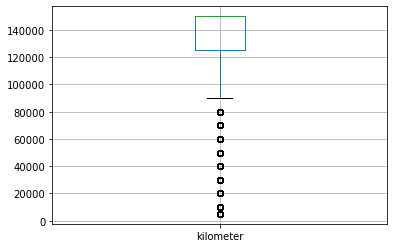

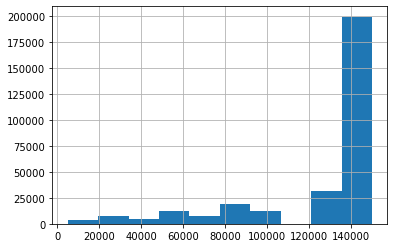

In [32]:
df.boxplot('kilometer');
plt.show()
df['kilometer'].hist();

Не думаю, что тут стоит что-то удалять, потому что пробег у машин может сильно разниться.

<b>Вывод: </b>С общей предобработкой все. Заменили пропуски на часто встречаемые значения, избавились от аномальных значений, удалили стобцы, которые не несут важной для нас информации.

## Обучение моделей

### Разбиение на выборки

In [33]:
features = df.drop('price', axis=1)
target = df['price']
print(features.shape)
print(target.shape)

(299355, 9)
(299355,)


In [34]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25,
                                                                            random_state = 12345)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(224516, 9)
(224516,)
(74839, 9)
(74839,)


### Обучение моделей

Закодируем категорильаные признаки в числовые с помощью OrdinalEncoder и объедим их с числовыми признаками в один датафрейм для последующей работы.

In [35]:
def encode(features_train, features_test):
    categorical = list(features_train.select_dtypes('object').columns)
    numerical = list(features_train.select_dtypes(exclude = 'object').columns)
    
    encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1)
    encoder.fit(features_train[categorical])
    features_train_encoded = pd.DataFrame(
        encoder.transform(features_train[categorical]),
        columns = categorical,
        index = features_train.index)

    features_test_encoded = pd.DataFrame(
        encoder.transform(features_test[categorical]),
        columns = categorical,
        index = features_test.index)
    features_train = pd.concat((features_train[numerical], features_train_encoded), axis = 1)
    features_test = pd.concat((features_test[numerical], features_test_encoded), axis = 1)
    
    return features_train, features_test

In [36]:
features_train, features_test = encode(features_train, features_test)

Для анализа возьмем линейную регрессию, случайный лес и LightGBM

Подбирать оптимальные параметры (rmse и время) будем с помощью GridSearchCV.

In [37]:
def GridSearch(model, parametrs):
    start = time.time()
    
    grid = GridSearchCV(model, parametrs,scoring= 'neg_mean_squared_error')
    grid.fit(features_train, target_train)
    
    end = time.time()
    
    parametrs = grid.best_params_
    rmse = (max(grid.cv_results_['mean_test_score']* -1))**0.5 
    lead_time = (end-start)/60
    return parametrs, rmse, lead_time

<b>Линейная регрессия</b>

In [38]:
warnings.filterwarnings('ignore')

In [39]:
model_linear = LinearRegression() 
parametrs = {'normalize': [True, False]}
parametrs_linear, rmse_linear, lead_time_linear = GridSearch(model_linear, parametrs) 
print('Лучшие параметры', parametrs_linear) 
print('RMSE:', {rmse_linear}) 
print('Время выполнения:', {lead_time_linear})

Лучшие параметры {'normalize': False}
RMSE: {3048.8333341899}
Время выполнения: {0.02226144870122274}


<b>Случайный лес</b>

In [40]:
model_forest = RandomForestRegressor() 
parametrs = {'n_estimators': range(1,10, 2), 
    'max_depth': range(1,10,2), 
    'min_samples_split': range(2, 6, 2), 
    'random_state' : [12345] }
parametrs_forest, rmse_forest, lead_time_forest = GridSearch(model_forest, parametrs) 
print('Лучшие параметры', parametrs_forest) 
print('RMSE:', {rmse_forest}) 
print('Время выполнения:', {lead_time_forest})

Лучшие параметры {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 9, 'random_state': 12345}
RMSE: {3755.849780804569}
Время выполнения: {4.112198746204376}


<b>LightGBM</b>

In [41]:
model_lgbm = LGBMRegressor() 
parametrs = [{'learning_rate': [0.1, 0.2, 0.5, 0.8], 
    'max_depth': [4, 16], 
    'random_state' : [12345],}]
parametrs_lgbm, rmse_lgbm, lead_time_lgbm = GridSearch(model_lgbm, parametrs) 
print('Лучшие параметры:', parametrs_lgbm) 
print('RMSE:', {rmse_lgbm}) 
print('Время выполнения:', {lead_time_lgbm})

Лучшие параметры: {'learning_rate': 0.5, 'max_depth': 16, 'random_state': 12345}
RMSE: {1829.2428845137204}
Время выполнения: {0.41902297337849936}


Напишем ф-ию, которая вычисляет время обучения модели и время, затраченное на предсказание на тренировочных данных. 

In [42]:
def work_time(model):
    start = time.time()    
    model.fit(features_train,target_train)
    end_train = time.time()
    
    model.predict(features_train)
    end_predict = time.time()
    end_total = time.time()
    
    tm_train = (end_train - start)
    tm_predict = (end_predict - end_train)
    tm_total = (end_total-start)
    
    return tm_train, tm_predict, tm_total

<b>Время линейной регрессии</b>

In [43]:
time_lin_train, time_lin_predict, time_lin_total = work_time(LinearRegression(normalize = False))

In [44]:
print('Тренировочное время:', time_lin_train)
print('Время предсказания:', time_lin_predict)
print('Общее:', time_lin_total)

Тренировочное время: 0.06071019172668457
Время предсказания: 0.02188563346862793
Общее: 0.0825958251953125


<b>Время слуачйного леса</b>

In [45]:
time_forest_train, time_forest_predict, time_forest_total = work_time(LinearRegression(normalize = False))

In [46]:
print('Тренировочное время:', time_forest_train)
print('Время предсказания:', time_forest_predict)
print('Общее:', time_forest_total)

Тренировочное время: 0.0750741958618164
Время предсказания: 0.016004323959350586
Общее: 0.09107851982116699


<b>Время LightGBM</b>

In [47]:
time_lgbm_train, time_lgbm_predict, time_lgbm_total = work_time(
    LGBMRegressor(learning_rate = 0.5, max_depth = 16, random_state = 12345))

In [48]:
print('Тренировочное время:', time_lgbm_train)
print('Время предсказания:', time_lgbm_predict)
print('Общее:', time_lgbm_total)

Тренировочное время: 1.018498182296753
Время предсказания: 0.271282434463501
Общее: 1.289780616760254


In [53]:
new_df = {'Linear_Regression': pd.Series([time_lin_train, time_lin_predict, time_lin_total, rmse_linear],
                                           index =['train_time','predict_time', 'total_time', 'RMSE'] ),
       'Random_Forest_regressor': pd.Series([time_forest_train, time_forest_predict, time_forest_total, rmse_forest],
                                           index = ['train_time','predict_time', 'total_time', 'RMSE']),
       'LGBMRegressor' : pd.Series([time_lgbm_train, time_lgbm_predict, time_lgbm_total, rmse_lgbm],
                                  index =['train_time','predict_time', 'total_time', 'RMSE'])
     }
new_df = pd.DataFrame(new_df)
new_df

,Linear_Regression,Random_Forest_regressor,LGBMRegressor
train_time,0.060710,0.075074,1.018498
predict_time,0.021886,0.016004,0.271282
total_time,0.082596,0.091079,1.289781
RMSE,3048.833334,3755.849781,1829.242885


<b>Вывод:</b> разбили данные на выборки, обучили несколько моделей (линейную регрессию, случайный лес и LightGBM) и также посмотрели на их время работы. RMSE оказался лучше всего у LightGBM - _1831_

## Анализ моделей

Т.к. лучшей моделью показал себя LightGBM с показателем RMSE = _1831_, то для итогового тестирования возьмем его

In [54]:
best_model = LGBMRegressor(learning_rate = 0.5, max_depth = 16, random_state = 12345)
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)

In [55]:
print((mean_squared_error(target_test, predictions))**.5)

1646.9055969120125


<b>Вывод:</b> Итоговое значение RMSE на LightGBM = _1646_, что является неплохим показателем => мы берем модель LightGBM  с параметрами: (learning_rate = 0.5, max_depth = 16, random_state = 12345) и временем выполнения:

    Тренировочное время: 1.018498182296753
    Время предсказания: 0.271282434463501
    Общее: 1.289780616760254

## Вывод

Данные были изучены и над ними была проведена предобработка, а именно: удалено несколько дупликатов, зполнены пропуски наиболее популярными значениями, удалены столбцы, которые не несут полезной информации и обработаны аномальные значения.

Далее данные были разбиты на выборки и с их помощью обучены модели линейной регресии, слуачйного леса и LightGBM. RMSE линейной регресии была равна _3048_, слуачйного леса - _3755_, LightGBM - _1829_, в следствии чего для дальнейшей работы была выбрана модель LightGBM.

Рабочее время LightGBM составляет:

    Тренировочное время: 1.018498182296753
    Время предсказания: 0.271282434463501
    Общее: 1.289780616760254
    
Лучшие параметры для LightGBM: (learning_rate = 0.5, max_depth = 16, random_state = 12345) и, наконец, показатель <b>RMSE</b> на итоговой модели: _1646_, что меньше, чем 2500 => наша задача выполнена.